# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Признаки**

DateCrawled — дата скачивания анкеты из базы

VehicleType — тип автомобильного кузова

RegistrationYear — год регистрации автомобиля

Gearbox — тип коробки передач

Power — мощность (л. с.)

Model — модель автомобиля

Kilometer — пробег (км)

RegistrationMonth — месяц регистрации автомобиля

FuelType — тип топлива

Brand — марка автомобиля

Repaired — была машина в ремонте или нет

DateCreated — дата создания анкеты

NumberOfPictures — количество фотографий автомобиля

PostalCode — почтовый индекс владельца анкеты (пользователя)

LastSeen — дата последней активности пользователя

**Целевой признак**

Price — цена (евро)

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.pipeline import  make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (19,5)
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor

In [2]:
data=pd.read_csv('/datasets/autos.csv')

In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Изучим наш дата фрейм

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
data.duplicated().sum()

4

Найдено 4 явных дубликата, удалим их

In [6]:
data.drop_duplicates(inplace=True)

In [7]:
data.isnull().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Пропуски в:

VehicleType - тип автомобильного кузова

Gearbox — тип коробки передач

Model -  модель автомобиля

FuelType — тип топлива

Repaired - была машина в ремонте или нет

Посчитаем количество строк хотя бы с одним пропуском

In [8]:
data.isnull().any(axis=1).sum()

108555

Это составляет

In [9]:
data.isnull().any(axis=1).sum()/data.shape[0]*100

30.63366867495379

30.6% от всех данных, это очень большое число, так что не можем просто удалить строки с отсуствующими данными

Начнем обработку пропусков

**VehicleType**

In [10]:
data['VehicleType'].value_counts()

sedan          91457
small          79830
wagon          65165
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: VehicleType, dtype: int64

Нет так называемого лидера, так что не можем заполнить пропуски одним определённым типом. Заменю пропуски на unknown

In [11]:
data['VehicleType'] = data['VehicleType'].fillna('unknown')

**Gearbox**

In [12]:
data['Gearbox'].value_counts()

manual    268249
auto       66283
Name: Gearbox, dtype: int64

Видим что машин типа manual гораздо больше, так что пропуски заполним именно этим

In [13]:
data['Gearbox'] = data['Gearbox'].fillna('manual')

**Model**

In [14]:
data['Model'].value_counts()

golf                  29232
other                 24420
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
serie_3                   4
rangerover                4
serie_1                   2
range_rover_evoque        2
Name: Model, Length: 250, dtype: int64

Cитуация аналогична с VehicleType заменим на unknown

In [15]:
data['Model'] = data['Model'].fillna('unknown')

**FuelType**

In [16]:
data['FuelType'].value_counts()

petrol      216349
gasoline     98719
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

пропуски заменим на petrol

In [17]:
data['FuelType'] = data['FuelType'].fillna('petrol')

**Repaired**

In [18]:
data['Repaired'].value_counts()

no     247158
yes     36053
Name: Repaired, dtype: int64

пропуски заменим на no

In [19]:
data['Repaired'] = data['Repaired'].fillna('no')

Проверим наличие пропусков

In [20]:
data.isnull().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

Удалим неинформативные признаки

In [21]:
data=data.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

In [22]:
data.duplicated().sum()

56543

Получили значительное число новых дубликатов

In [23]:
data.drop_duplicates(inplace=True)

In [24]:
data.describe()

,Price,RegistrationYear,Power,Kilometer
count,297822.000000,297822.000000,297822.000000,297822.000000
mean,4563.171589,2004.435670,111.961027,126680.114296
std,4593.363691,94.212298,204.443324,38852.069958
min,0.000000,1000.000000,0.000000,5000.000000
25%,1111.000000,1999.000000,69.000000,125000.000000
50%,2890.000000,2003.000000,105.000000,150000.000000
75%,6599.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


Начнём обработку аномалий

**Price**

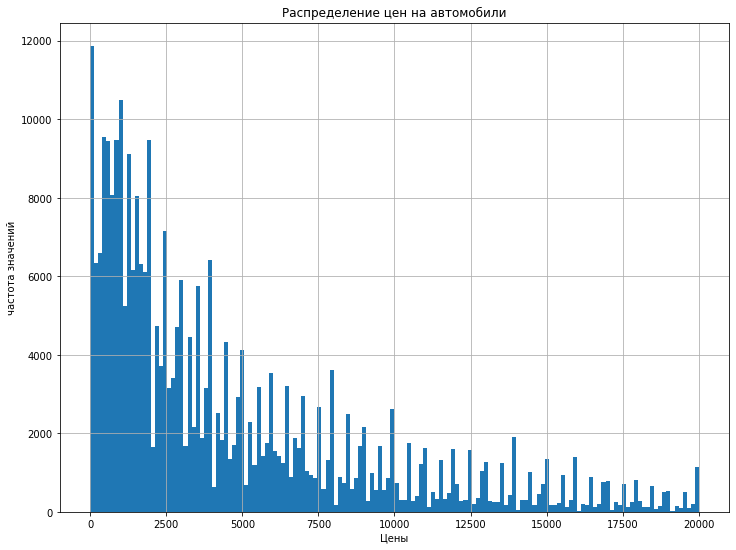

In [25]:
data['Price'].hist(bins=150, figsize=(12,9))
plt.title("Распределение цен на автомобили")
plt.xlabel('Цены')
plt.ylabel('частота значений')
plt.show()

In [26]:
data.query('Price < 1000')['Price'].count()

67543

Вряд ли машин стоит меньше 1000 евро 

In [27]:
data=data.query('Price >= 1000')

**RegistrationYear**

Есть машины с годом регистрации автомобиля 1000, тогда еще не существовало машин, либо 9999 год. Рассмотрим машины с 1980 года регистрации до 2016 года

In [28]:
data=data.query('1980 <= RegistrationYear <=2016 ')

**Power**

Аналогично с годом регистрации нет машины с 0 л.с. либо с 20 тысячью

In [29]:
data=data.query('50 <= Power <=1500 ')

В признаке Kilometer не замечено аномалий

**Вывод**

1) Выявили явные дубликаты. Удалили

2) Обработали пропуски в столбцах VehicleType, Gearbox, Model, FuelType, Repaired 

3) Удалили неинформативные признаки 

4) Обработали аномалии в столбцах Price, Power, RegistrationYear 

## Обучение моделей

Будем обучать модели:

LGBMRegressor

DecisionTreeRegressor

In [30]:
data_train, data_test = train_test_split(data, test_size=0.25, random_state=12345)

data_train_encoded = pd.get_dummies(data_train, columns=["Brand", "Model", "VehicleType", "Gearbox", "FuelType", "Repaired"])
data_test_encoded = pd.get_dummies(data_test, columns=["Brand", "Model", "VehicleType", "Gearbox", "FuelType", "Repaired"])


common_columns = set(data_train_encoded.columns) & set(data_test_encoded.columns)
data_train_encoded = data_train_encoded[list(common_columns)]
data_test_encoded = data_test_encoded[list(common_columns)]

features_train = data_train_encoded.drop("Price", axis=1)
target_train = data_train_encoded["Price"]
features_test = data_test_encoded.drop("Price", axis=1)
target_test = data_test_encoded["Price"]

if not np.array_equal(features_train.columns, features_test.columns):
    print("Ошибка: порядок или названия признаков в выборках не совпадают!")
else:
    print("Выборки успешно подготовлены для обучения модели.")

Выборки успешно подготовлены для обучения модели.


In [31]:
model_dtr = Pipeline([('preprocessor', ColumnTransformer([('scaler', MinMaxScaler(), ['Kilometer', 'Power', 'RegistrationYear'])], remainder='passthrough')),
                      ('regressor', DecisionTreeRegressor(random_state=12345))])


In [32]:
parameters_dtr = {'regressor__max_depth':range(1,10)}
grid_search_dtr = GridSearchCV(model_dtr, param_grid=parameters_dtr,  scoring='neg_root_mean_squared_error',cv=5)
grid_search_dtr.fit(features_train,target_train)
print("Лучшие гиперпараметры для DecisionTreeRegressor: ", grid_search_dtr.best_params_)
print("Лучшее значение метрики для DecisionTreeRegressor: ", -(grid_search_dtr.best_score_))

Лучшие гиперпараметры для DecisionTreeRegressor:  {'regressor__max_depth': 9}
Лучшее значение метрики для DecisionTreeRegressor:  2145.6248128868647


In [33]:
model_lgbm = Pipeline([
    ('preprocessor', ColumnTransformer([('scaler', MinMaxScaler(), ['Kilometer', 'Power','RegistrationYear'])], remainder='passthrough')),
    ('regressor', LGBMRegressor(random_state=12345))])
parameters_lgbm = {'regressor__num_leaves':[50, 100],'regressor__learning_rate':[0.1, 0.3] }
grid_search_lgbm = GridSearchCV(model_lgbm, param_grid=parameters_lgbm,  scoring='neg_root_mean_squared_error',cv=5)
grid_search_lgbm.fit(features_train,target_train)
print("Лучшие гиперпараметры для DecisionTreeRegressor: ", grid_search_lgbm.best_params_)
print("Лучшее значение метрики для DecisionTreeRegressor: ", -(grid_search_lgbm.best_score_))

Лучшие гиперпараметры для DecisionTreeRegressor:  {'regressor__learning_rate': 0.3, 'regressor__num_leaves': 100}
Лучшее значение метрики для DecisionTreeRegressor:  1644.2110192903813


Найдем время обучения и время предсказывания каждой модели

In [34]:
model_dtr = DecisionTreeRegressor(random_state = 12345, max_depth=9) 
model_lgbm=LGBMRegressor(random_state = 12345, learning_rate=0.3,num_leaves=100)

In [35]:
%%time
model_dtr.fit(features_train, target_train)

CPU times: user 2.58 s, sys: 135 ms, total: 2.71 s
Wall time: 2.71 s


DecisionTreeRegressor(max_depth=9, random_state=12345)

In [36]:
%%time
model_dtr.predict(features_train)

CPU times: user 123 ms, sys: 151 ms, total: 274 ms
Wall time: 281 ms


array([ 8686.7208589 , 10452.45368171, 12169.78660287, ...,
        5489.19817768,  5706.51740139,  7545.875     ])

In [37]:
%%time
model_lgbm.fit(features_train, target_train)

CPU times: user 1min 16s, sys: 707 ms, total: 1min 17s
Wall time: 1min 18s


LGBMRegressor(learning_rate=0.3, num_leaves=100, random_state=12345)

In [38]:
%%time
model_lgbm.predict(features_train)

CPU times: user 1.97 s, sys: 186 ms, total: 2.15 s
Wall time: 2.21 s


array([ 8673.01298033, 13123.58666473, 11982.27342492, ...,
        3003.87245537,  5469.55246186,  6895.41553429])

На тренировочной выборке лучший результат показа модель lgbm, но обучалась значительно дольше, с учётом критериев заказчика, выберу модель DecisionTreeRegressor, 

## Анализ моделей

Проверим наши модели на тестовой выборке

In [39]:
%%time 

model_dtr=DecisionTreeRegressor(max_depth=9,random_state=12345)
model_dtr.fit(features_train,target_train)
prediction=model_dtr.predict(features_test)
print("rmse :", mean_squared_error(target_test,prediction)**.5)

rmse : 2151.438183905267
CPU times: user 2.58 s, sys: 187 ms, total: 2.77 s
Wall time: 2.8 s


Проверим модель на адекватность 

In [40]:
dummy = DummyRegressor(strategy='mean')
dummy.fit(features_train, target_train)
predictions = dummy.predict(features_test)
print("rmse :", mean_squared_error(target_test,predictions)**.5)

rmse : 4631.48290143096


Получили что константная модель имеет значение rmse хуже, значит наша модель адекватна и эффективна

# Вывод 

В ходе работы выполнили предобработку данных:

1) Выявили явные дубликаты. Удалили

2) Обработали пропуски в столбцах VehicleType, Gearbox, Model, FuelType, Repaired

3) Удалили неинформативные признаки

4) Обработали аномалии в столбцах Price, Power, RegistrationYear

Затем обучили модели LGBMRegressor и DecisionTreeRegressor, на обучающей выборке выборке лучший результат был у LGBMRegressor, однако DecisionTreeRegressor обучалась и предсказывала значительно быстрее, поэтому выбрали ее

На тестовой выборке модель DecisionTreeRegressor показала результат 2151, что удовлетворяет условиям. Также модель прошла проверку на адекватность, поэтому можем запускать ее в производство